<a href="https://colab.research.google.com/github/nguyenhuy-vn/Finger-identification-based-on-capacitives-touch-screen/blob/main/SqueezeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras import datasets, models, layers

### Load data

In [3]:
X_train = np.load('/content/drive/MyDrive/data_for_2/X_train.npy')
X_test = np.load('/content/drive/MyDrive/data_for_2/X_test.npy')
X_val = np.load('/content/drive/MyDrive/data_for_2/X_val.npy')
Y_train = np.load('/content/drive/MyDrive/data_for_2/Y_train.npy')
Y_test = np.load('/content/drive/MyDrive/data_for_2/Y_test.npy')
Y_val = np.load('/content/drive/MyDrive/data_for_2/Y_val.npy')
label = np.load('/content/drive/MyDrive/data_for_2/label.npy')

### Check if have any missing data

In [4]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((61122, 32, 32),
 (19168, 32, 32),
 (15281, 32, 32),
 (61122, 2),
 (19168, 2),
 (15281, 2))

In [5]:
X_train[0]

array([[0.02745098, 0.02745098, 0.02745098, ..., 0.04313726, 0.04313726,
        0.04313726],
       [0.02745098, 0.02745098, 0.02745098, ..., 0.04313726, 0.04313726,
        0.04313726],
       [0.02745098, 0.02745098, 0.02745098, ..., 0.04313726, 0.04313726,
        0.04313726],
       ...,
       [0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.07058824,
        0.07058824]], dtype=float32)

In [6]:
X_val[0]

array([[0.00784314, 0.00784314, 0.00784314, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.02745098, 0.02745098,
        0.02745098],
       ...,
       [0.01568628, 0.01568628, 0.01568628, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.07058824, 0.07058824,
        0.07058824]], dtype=float32)

In [7]:
Y_train[0]

array([0., 1.])

### Model and Train

In [8]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0],32,32,1)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [32]:
from keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, GlobalAveragePooling2D
from keras.layers import Dropout, Activation, Flatten, Dense
from keras.models import Model

class FireModule(Model):
    def __init__(self, squeeze_filters, expand_filters):
        super(FireModule, self).__init__()
        self.squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal')
        self.expand1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal')
        self.expand3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')
        self.concat = Concatenate(axis=-1)

    def call(self, inputs):
        x = self.squeeze(inputs)
        expand1x1 = self.expand1x1(x)
        expand3x3 = self.expand3x3(x)
        return self.concat([expand1x1, expand3x3])


class SqueezeNet(Model):
    def __init__(self, num_classes, **kwargs):
        super(SqueezeNet, self).__init__()
        self.conv1 = Conv2D(96, (7, 7), activation='relu', strides=(2, 2), padding='same', kernel_initializer='he_normal')
        self.maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding = 'same')

        self.fire2 = FireModule(squeeze_filters=16, expand_filters=64)
        self.fire3 = FireModule(squeeze_filters=16, expand_filters=64)
        self.fire4 = FireModule(squeeze_filters=32, expand_filters=128)
        self.maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding  = 'same')

        self.fire5 = FireModule(squeeze_filters=32, expand_filters=128)
        self.fire6 = FireModule(squeeze_filters=48, expand_filters=192)
        self.fire7 = FireModule(squeeze_filters=48, expand_filters=192)
        self.fire8 = FireModule(squeeze_filters=64, expand_filters=256)
        self.maxpool8 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')

        self.fire9 = FireModule(squeeze_filters=64, expand_filters=256)
        self.dropout = Dropout(0.5)

        self.conv10 = Conv2D(num_classes, (1, 1), activation='relu', padding='valid', kernel_initializer='he_normal')
        self.global_avgpool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation = 'softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)

        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.maxpool4(x)

        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.maxpool8(x)

        x = self.fire9(x)
        x = self.dropout(x)

        x = self.conv10(x)
        x = self.global_avgpool(x)
        x = self.flat(x)
        out = self.fc(x)

        return out


In [33]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [34]:
model = SqueezeNet(2)
model.build(input_shape = (None, 32, 32, 1))
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy", f1_m, precision_m, recall_m])
model.summary()

Model: "squeeze_net_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          multiple                  4800      
                                                                 
 max_pooling2d_11 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 fire_module_28 (FireModule  multiple                  11920     
 )                                                               
                                                                 
 fire_module_29 (FireModule  multiple                  12432     
 )                                                               
                                                                 
 fire_module_30 (FireModule  multiple                  45344     
 )                                                   

In [35]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuracy")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs= 50, validation_data=(X_val, Y_val),callbacks=[es])

Epoch 1/50
238/238 [==============================] - 33s 91ms/step - loss: 0.6920 - accuracy: 0.5233 - f1_m: 0.5233 - precision_m: 0.5233 - recall_m: 0.5233 - val_loss: 0.6923 - val_accuracy: 0.5210 - val_f1_m: 0.5210 - val_precision_m: 0.5210 - val_recall_m: 0.5210
Epoch 2/50
238/238 [==============================] - 20s 83ms/step - loss: 0.6920 - accuracy: 0.5236 - f1_m: 0.5236 - precision_m: 0.5236 - recall_m: 0.5236 - val_loss: 0.6923 - val_accuracy: 0.5210 - val_f1_m: 0.5210 - val_precision_m: 0.5210 - val_recall_m: 0.5210
Epoch 3/50
238/238 [==============================] - 22s 90ms/step - loss: 0.6921 - accuracy: 0.5236 - f1_m: 0.5236 - precision_m: 0.5236 - recall_m: 0.5236 - val_loss: 0.6923 - val_accuracy: 0.5210 - val_f1_m: 0.5210 - val_precision_m: 0.5210 - val_recall_m: 0.5210
Epoch 4/50
238/238 [==============================] - 22s 90ms/step - loss: 0.6921 - accuracy: 0.5236 - f1_m: 0.5237 - precision_m: 0.5237 - recall_m: 0.5237 - val_loss: 0.6923 - val_accuracy: 0.5

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


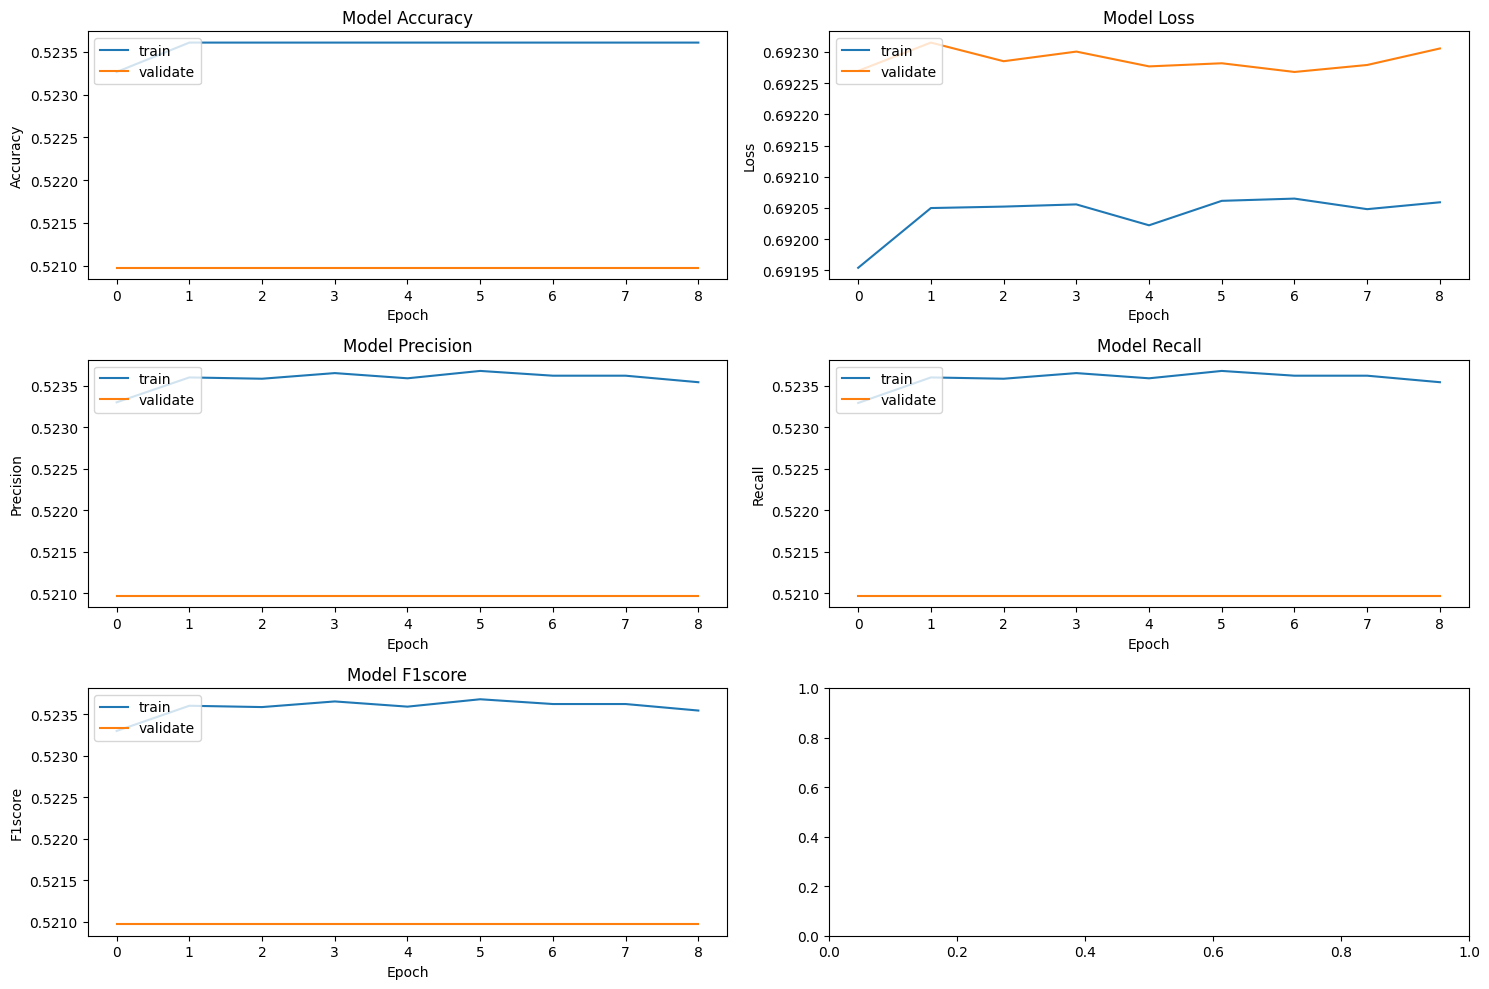

In [36]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Plot accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['train', 'validate'], loc='upper left')

    # Plot loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['train', 'validate'], loc='upper left')

    # Plot precision_m
    axs[1, 0].plot(history.history['precision_m'])
    axs[1, 0].plot(history.history['val_precision_m'])
    axs[1, 0].set_title('Model Precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['train', 'validate'], loc='upper left')

    # Plot recall_m
    axs[1, 1].plot(history.history['recall_m'])
    axs[1, 1].plot(history.history['val_recall_m'])
    axs[1, 1].set_title('Model Recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['train', 'validate'], loc='upper left')

    # Plot f1score_m
    axs[2, 0].plot(history.history['f1_m'])
    axs[2, 0].plot(history.history['val_f1_m'])
    axs[2, 0].set_title('Model F1score')
    axs[2, 0].set_ylabel('F1score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['train', 'validate'], loc='upper left')

    plt.tight_layout()
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [15]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_test, Y_test, verbose=0)
print("Loss of test set is: ",lost_test)
print("Accuracy of test set is: ",accuracy_test)
print("F1score of test set is: ",f1score_test)
print("Precision of test set is: ",precision_test)
print("Recall of test set is: ",recall_test)

Loss of test set is:  0.6875556111335754
Accuracy of test set is:  0.5703255534172058
F1score of test set is:  0.5703255534172058
Precision of test set is:  0.5703255534172058
Recall of test set is:  0.5703255534172058


### Draw confusion matrix

In [16]:
label

array(['right thumb', 'left thumb'], dtype='<U11')

In [17]:
labels = list(label)
labels

['right thumb', 'left thumb']

1911/1911 [==============================] - 8s 4ms/step


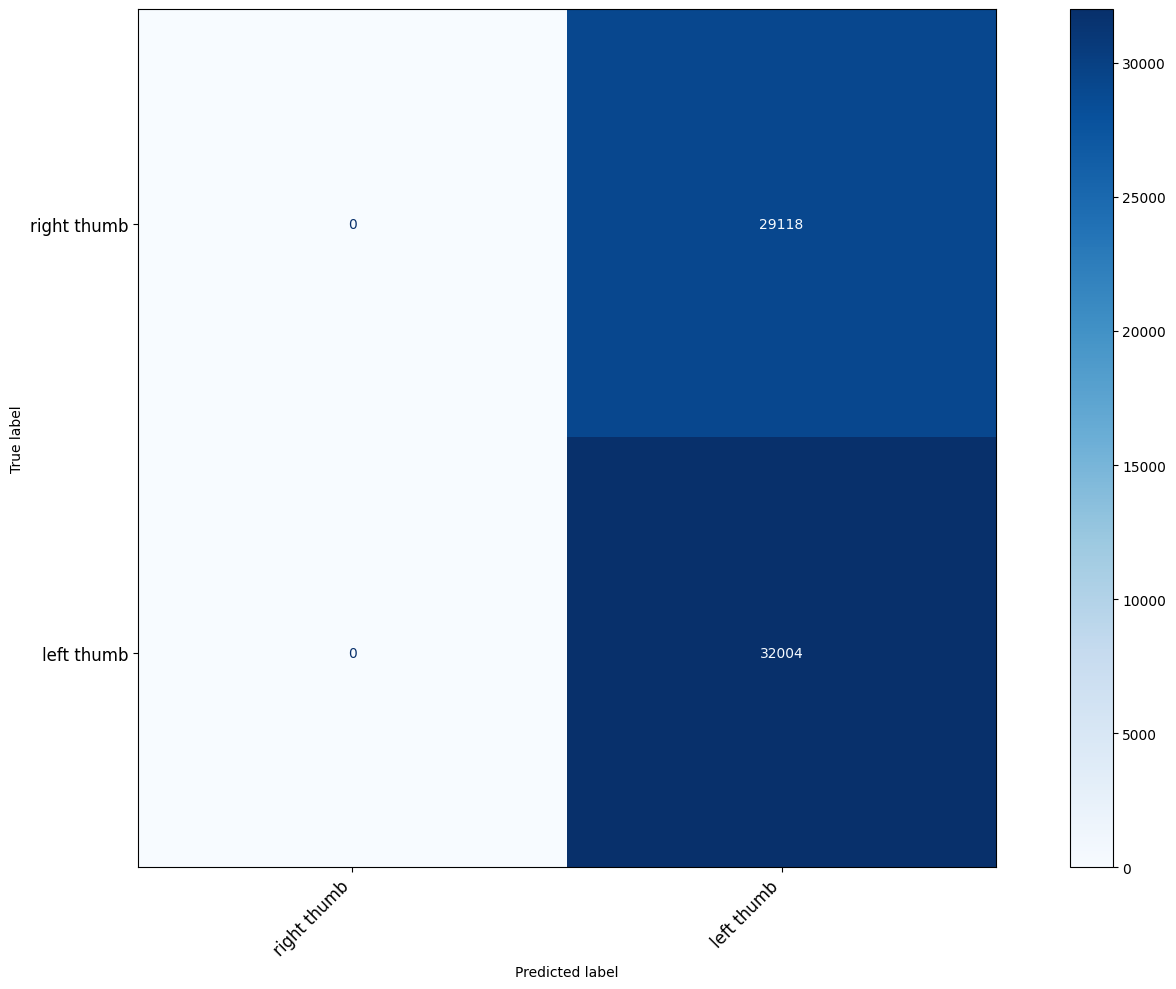

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_train, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


In [19]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((61122, 32, 32, 1), (61122, 2), (19168, 32, 32, 1), (19168, 2))

599/599 [==============================] - 2s 4ms/step


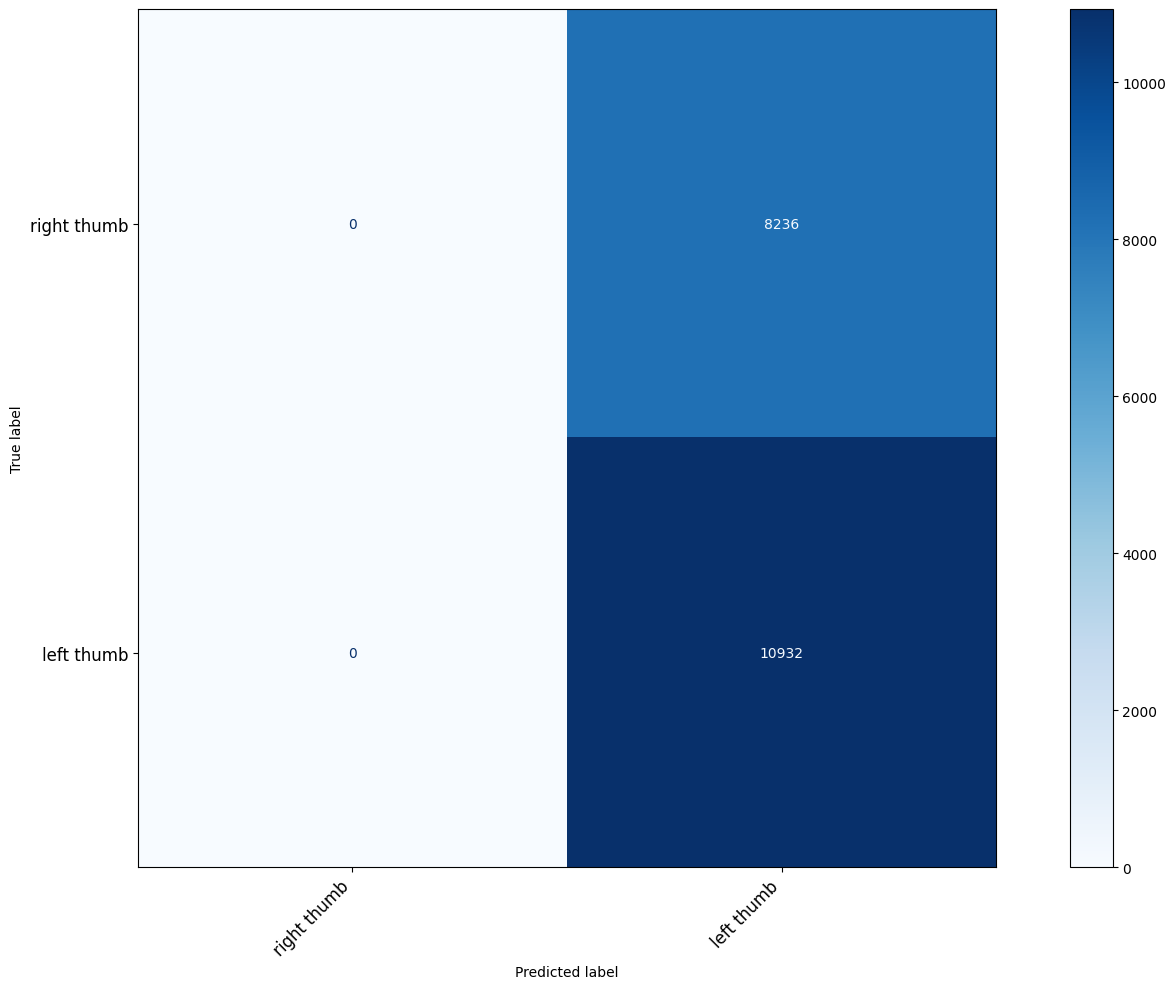

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()
